# Main of the paper - logistic and deterministic

In this notebook are gathered all experiments generated for the main of the paper which requires logistic regression and a deterministic gradients.

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, SGD_Descent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.data.RealDatasetPreparation import prepare_quantum
from src.utils.Constants import *
from src.utils.data.DataClustering import *
from src.utils.data.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "logistic_deterministic"

nb_devices_for_the_run = 20
dim_notebook = 2

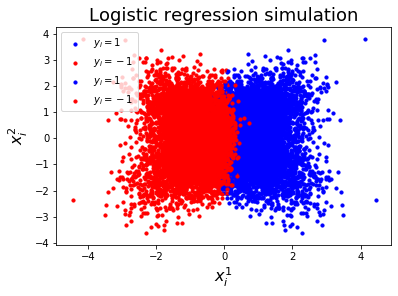

In [2]:
w = torch.FloatTensor([10, 10]).to(dtype=torch.float64)
w_true = torch.FloatTensor([10.0, 0.0]).to(dtype=torch.float64)
X_check, Y_check = build_data_logistic(w_true, n_samples = 10000, n_dimensions = dim_notebook, n_devices=10, with_seed=False)

logistic_plot(X_check[0], Y_check[0])
logistic_plot(X_check[1], Y_check[1])
plt.show()

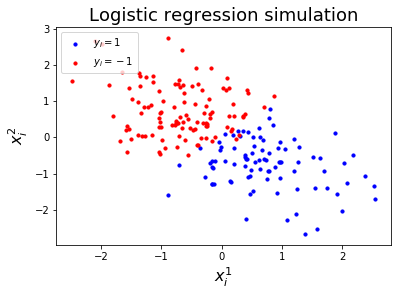

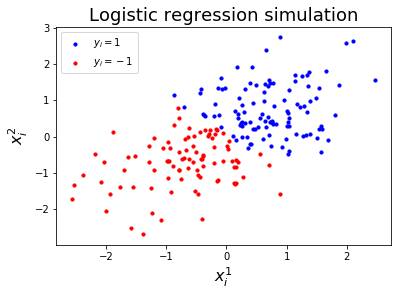

In [3]:
#w = torch.FloatTensor([0, 1000]).to(dtype=torch.float64) # Same w but different distribution (remove w modif)
w = torch.FloatTensor([10, 10]).to(dtype=torch.float64)
w_true = torch.FloatTensor([10, 0]).to(dtype=torch.float64)
X, Y = build_data_logistic(w, n_dimensions = dim_notebook,
                           n_devices=nb_devices_for_the_run, with_seed=False)
pickle_saver((X, Y), filename + "-data")
for i in range(0, 2, 1):
    logistic_plot(X[i], Y[i])
    plt.show()

In [4]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [5]:
%%time
obj_min_by_N_descent = SGD_Descent(Parameters(n_dimensions = dim_notebook, 
                                                     nb_devices=nb_devices_for_the_run,
                                                     nb_epoch=2000, 
                                                     momentum = 0., 
                                                     verbose=True, 
                                                     cost_models=cost_models,
                                                     stochastic=False,
                                                     bidirectional=False
                                                    ))
obj_min_by_N_descent.run(cost_models)
obj_min_by_N = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

   it    |   obj   
     400 | 3.1754e-01
     800 | 3.1754e-01
    1200 | 3.1754e-01
    1600 | 3.1754e-01
Gradient Descent: execution time=57.952 seconds
Final loss : 0.31754

CPU times: user 13.7 s, sys: 0 ns, total: 13.7 s
Wall time: 58 s


In [6]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, nb_epoch=400, stochastic=False,
                                              compression_model = SQuantization(1, dim_notebook+1))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [08:12<00:00, 98.40s/it]


CPU times: user 1min 51s, sys: 257 ms, total: 1min 51s
Wall time: 8min 14s


### With averaging

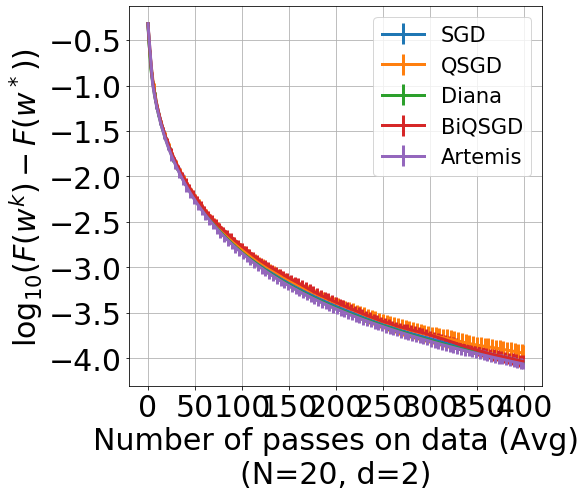

In [7]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data (Avg)")


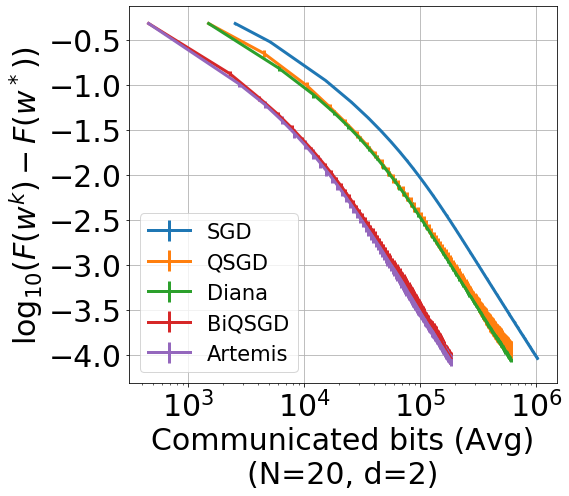

In [8]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


### Without averaging

../src/utils/runner/ResultsOfSeveralDescents.py:49: RuntimeWarning: divide by zero encountered in log10
  log_losses = [np.log10(loss - obj) for loss in losses]
../src/utils/runner/ResultsOfSeveralDescents.py:49: RuntimeWarning: invalid value encountered in log10
  log_losses = [np.log10(loss - obj) for loss in losses]
../src/utils/runner/ResultsOfSeveralDescents.py:70: RuntimeWarning: divide by zero encountered in log10
  log_losses = [np.log10(loss - obj) for loss in losses]
../src/utils/runner/ResultsOfSeveralDescents.py:70: RuntimeWarning: invalid value encountered in log10
  log_losses = [np.log10(loss - obj) for loss in losses]
/home/labcmap/constantin.philippenko/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


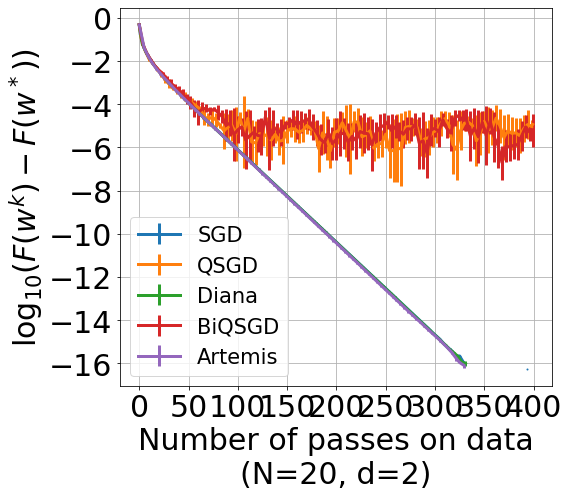

In [9]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj))

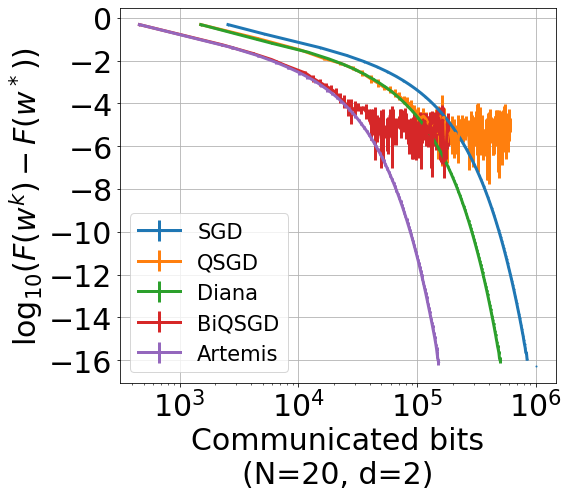

In [10]:
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 

## Devices sampling

In [11]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, fraction_sampled_workers=0.5,
                                               use_averaging=True, nb_epoch=400, stochastic=False,
                                              compression_model = SQuantization(1, dim_notebook+1))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent-ds")

100%|██████████| 5/5 [06:12<00:00, 74.44s/it]


CPU times: user 1min 23s, sys: 137 ms, total: 1min 23s
Wall time: 6min 15s


### With averaging

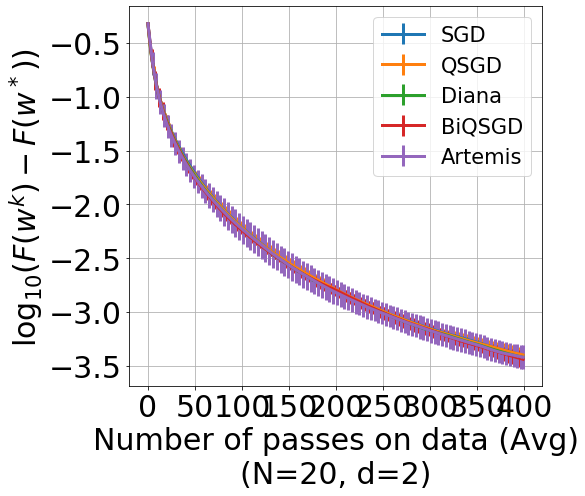

In [12]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent-ds")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data (Avg)")

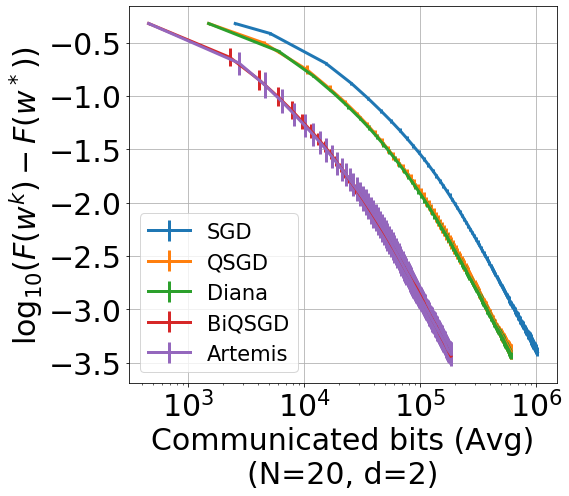

In [13]:
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


### Without averaging

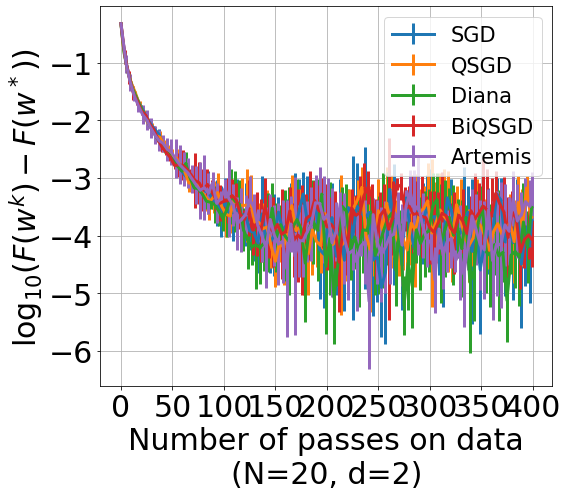

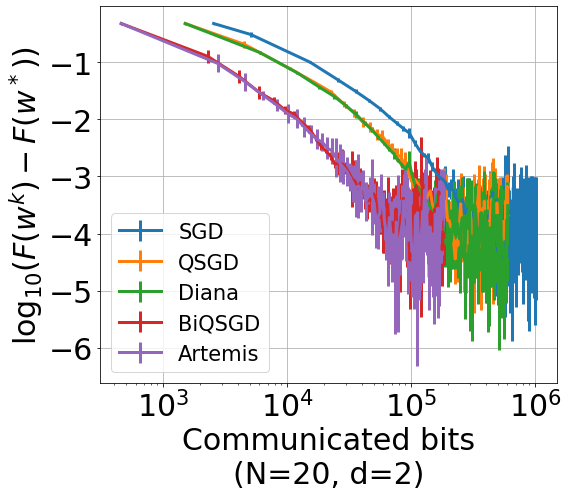

In [14]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent-ds")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj))
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 